In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers, losses
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import  l2
import os
import zipfile
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

In [2]:
class Inception_Net:
    
    def __init__(self): 
        pass
    
    def __conv2d_bn(self, inp, filters, kernel_size, padding='same', strides=(1, 1), name=None):
        
        if name is not None:
            conv2d_name = name + "_conv2d"
            bn_name = name + "_bn"
        else:
            conv2d_name = "Conv2d"
            bn_name = "bn"
        
        layer = Conv2D(filters=filters, 
                       kernel_size=kernel_size,
                       strides=strides,
                       padding=padding,
                       name=conv2d_name)(inp)
        
        layer = BatchNormalization(axis=3, 
                                   scale=False,
                                   name=bn_name)(layer) # assume channels_last
        
        out_tensor = Activation(tf.nn.relu)(layer)
        
        return out_tensor
    
    def __Inception_With_Dimension_Reduction(self, in_layer, f1x1, f3x3_red, f3x3, fpool, name=None):
        
        # #1×1 conv
        conv1x1 = self.__conv2d_bn(inp=in_layer, filters=f1x1, kernel_size=(1,1), padding='same', name=name+"_1x1_")

        # 3x3 reduce (#3×3reduce) and #3x3 conv
        conv3x3_red = self.__conv2d_bn(inp=in_layer, filters=f3x3_red, kernel_size=(1,1), padding='same', name=name+"_3x3_reduce_")
        conv3x3 = self.__conv2d_bn(inp=conv3x3_red, filters=f3x3, kernel_size=(3,3), padding='same', name=name+"_3x3_")

        # 3x3 max pooling and 1x1 projection layer - poolproj
        pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same', name=name + "_MaxPool2d")(in_layer)
        pool = self.__conv2d_bn(inp=pool, filters=fpool, kernel_size=(1,1), padding='same', name=name+"_1x1_projection_")

        # concatenate the convolutional layers , poling layer to be passed
        # onto the next layers.
        out_layer = concatenate([conv1x1, conv3x3, pool], axis=-1, name=name+"_concat")
        
        return out_layer
    
    def __IncepAuxiliaryClassifierModule(self, inp_tensor, num_classes, name=None):
        
        
        aux = AveragePooling2D(pool_size=(5, 5), strides=3, name=name+"_AvgPool2d")(inp_tensor)
        aux = Conv2D(filters=128, kernel_size=1, strides=1, padding='same', activation=tf.nn.relu, name=name+"_1x1_Conv2d")(aux)
        aux = Flatten()(aux)
        aux = Dense(1024, activation=tf.nn.relu)(aux)
        aux = Dropout(0.7)(aux)
        aux = Dense(units=num_classes, activation=tf.nn.softmax, name=name+"_dense")(aux)
        
        return aux
        
    def Build_Sample_Inception_Network(self, INPUT_SHAPE=(299, 299, 3)):
        
        # define model input
        inp = Input(shape = INPUT_SHAPE)
        
        # add inception block 1
        incep1 = self.__Inception_With_Dimension_Reduction(in_layer=inp, f1x1=64, f3x3_red=96, f3x3=128, 
                                                                fpool=32, name="inception1")
        
        # add inception block 2
        incep2 = self.__Inception_With_Dimension_Reduction(in_layer=incep1, f1x1=128, f3x3_red=128, f3x3=192, 
                                                                fpool=32, name="inception2")

        gap = GlobalAveragePooling2D(data_format='channels_last')(incep2)
        dense = Dense(1024, activation=tf.nn.relu)(gap)
        dropout = Dropout(0.4)(dense)
        out  = Dense(1, activation='sigmoid')(dropout)

        # create model
        model = Model(inputs=inp, outputs=out, name='inception_network')
        
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        
        # summarize model
        print(model.summary())
        return model

    
    def Inception_model(self, num_classes, INPUT_SHAPE=(299, 299, 3)):
    
        inp = Input(shape=INPUT_SHAPE)
        
        x = Conv2D(filters=64, kernel_size=7, strides=2, padding='same', activation=tf.nn.relu)(inp)
        x = MaxPooling2D(pool_size=(3,3), strides=2)(x)
        x = Conv2D(filters=64, kernel_size=1, strides=1, padding='same', activation=tf.nn.relu)(x)
        x = Conv2D(filters=192, kernel_size=3, strides=1, padding='same', activation=tf.nn.relu)(x)
        x = MaxPooling2D(pool_size=3, strides=2)(x)
        
        inception3A = self.__Inception_With_Dimension_Reduction(in_layer=x, 
                                                                f1x1=64, 
                                                                f3x3_red=96, 
                                                                f3x3=128,  
                                                                fpool=32,
                                                                name="inception3a")
        
        inception3B = self.__Inception_With_Dimension_Reduction(in_layer=inception3A,
                                                                f1x1=128,
                                                                f3x3_red=128,
                                                                f3x3=192,
                                                                fpool=64,
                                                                name="inception3b")
        
        pool = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same', name="MaxPool2d_1")(inception3B)
        
        inception4A = self.__Inception_With_Dimension_Reduction(in_layer=pool,
                                                                f1x1=192,
                                                                f3x3_red=96,
                                                                f3x3=208,
                                                                fpool=64,
                                                                name="inception4a")
        
        aux1 = self.__IncepAuxiliaryClassifierModule(inp_tensor=inception4A, num_classes=num_classes, name="auxiliary1")
        
        inception4B = self.__Inception_With_Dimension_Reduction(in_layer=inception4A,
                                                                f1x1=160,
                                                                f3x3_red=112,
                                                                f3x3=224,
                                                                fpool=64,
                                                                name="inception4b")
        
        inception4C = self.__Inception_With_Dimension_Reduction(in_layer=inception4B,
                                                                f1x1=128,
                                                                f3x3_red=128,
                                                                f3x3=256,
                                                                fpool=64,
                                                                name="inception4c")
        
        inception4D = self.__Inception_With_Dimension_Reduction(in_layer=inception4C,
                                                                f1x1=112,
                                                                f3x3_red=144,
                                                                f3x3=288,
                                                                fpool=64,
                                                                name="inception4d")
        
        aux2 = self.__IncepAuxiliaryClassifierModule(inp_tensor=inception4D, num_classes=num_classes, name="auxiliary2")
        
        inception4E = self.__Inception_With_Dimension_Reduction(in_layer=inception4D,
                                                                f1x1=256,
                                                                f3x3_red=160,
                                                                f3x3=320,
                                                                fpool=128,
                                                                name="inception4e")
        
        pool = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same', name="MaxPool2d_2")(inception4E)
        
        inception5A = self.__Inception_With_Dimension_Reduction(in_layer=inception4E,
                                                                f1x1=256,
                                                                f3x3_red=160,
                                                                f3x3=320,
                                                                fpool=128,
                                                                name="inception5a")
        
        inception5B = self.__Inception_With_Dimension_Reduction(in_layer=inception5A,
                                                                f1x1=384,
                                                                f3x3_red=192,
                                                                f3x3=384,
                                                                fpool=128,
                                                                name="inception5b")
        
        GAP = GlobalAveragePooling2D(data_format='channels_last')(inception5B)
        dropout = Dropout(0.4)(GAP)
        out = Dense(units=num_classes, activation=tf.nn.softmax, name="GoogLeNet_Dense_Output")(dropout)

        # Create & Compile the model
        # During training, the auxillary loss gets added to the total loss of the
        # network with a discount weight (the losses of the auxiliary classifiers were weighted by 0.3). 
        model = Model(inputs=inp, outputs=[out, aux1, aux2], name='GoogLeNet_Inception')
        
        model.compile(optimizer=tf.keras.optimizers.RMSprop(0.01),
          loss=[tf.keras.losses.CategoricalCrossentropy(),tf.keras.losses.MeanAbsoluteError(),tf.keras.losses.MeanSquaredError()],
          metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.SpecificityAtSensitivity(0.5),tfa.metrics.F1Score(num_classes=5, threshold=0.5),tf.keras.metrics.AUC(num_thresholds=5)
])
        # summarize model
        print(model.summary())
        
        return model

In [3]:
Inception = Inception_Net()

In [4]:
model_I = Inception.Inception_model(num_classes=5)

Metal device set to: Apple M2


2023-01-11 23:29:27.046475: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-11 23:29:27.046567: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "GoogLeNet_Inception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 150, 150, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 74, 74, 64)   0           ['conv2d[0][0]']                 
                                                                                

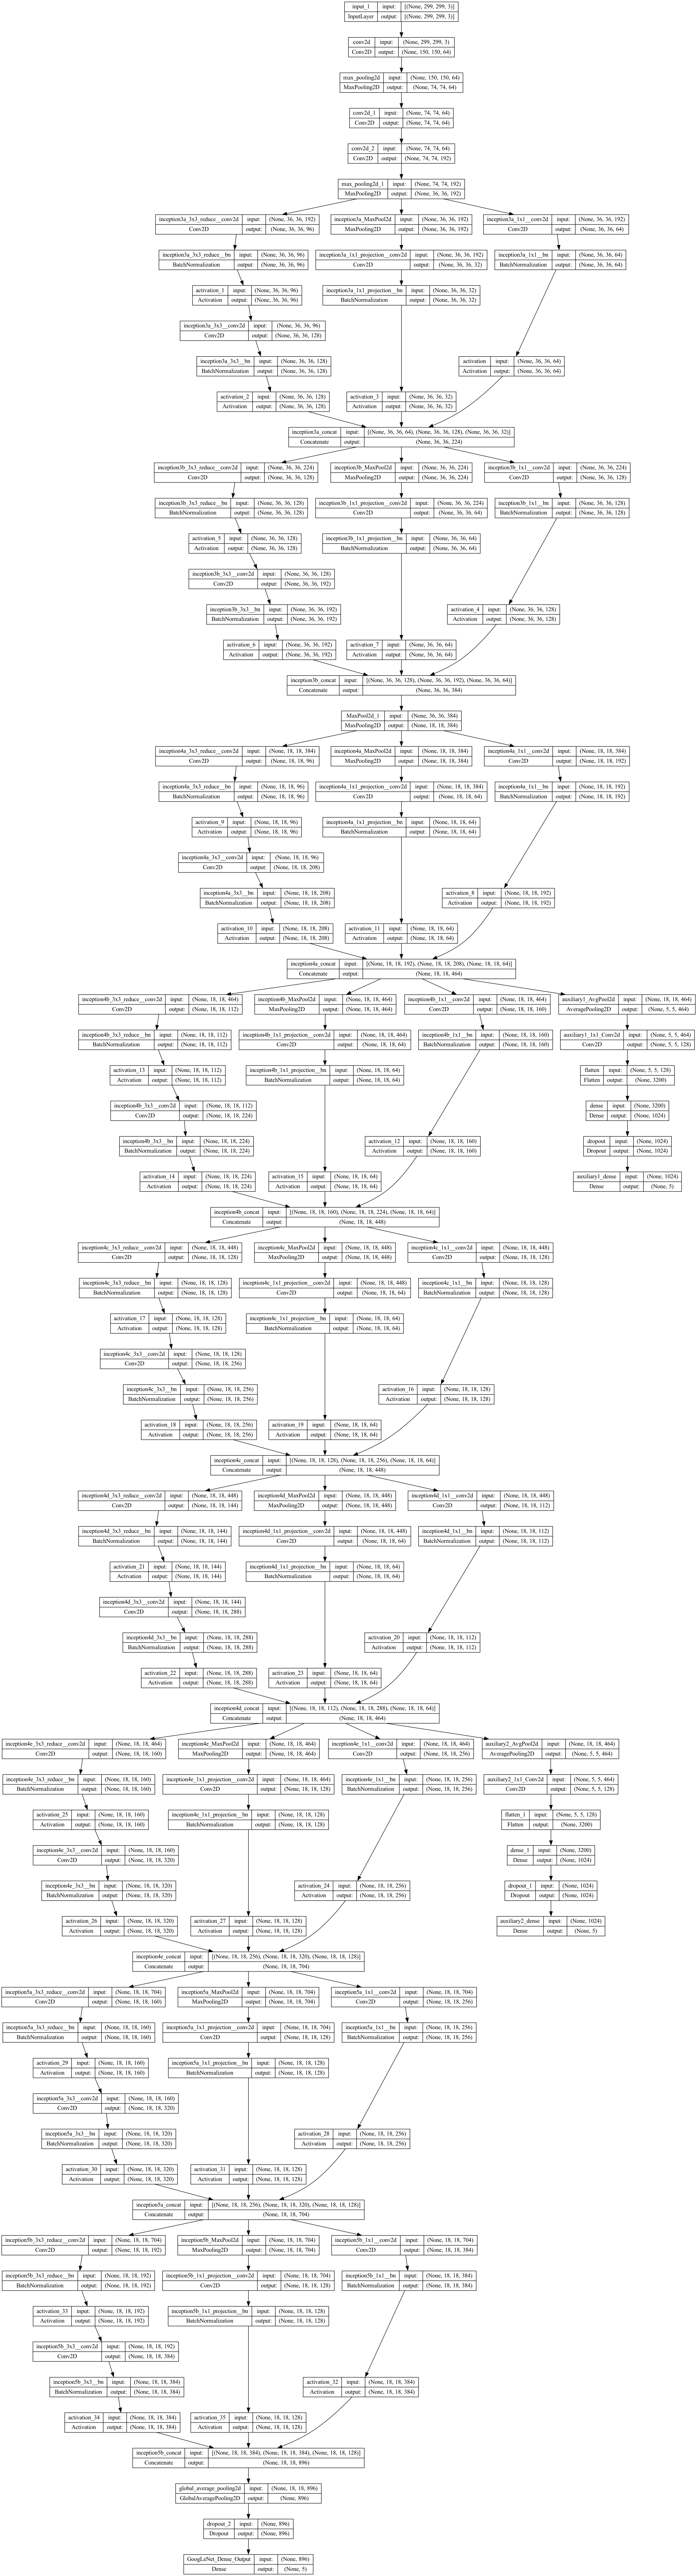

In [5]:
plot_model(model_I, show_shapes=True, to_file='InceptionNet_3x3.png')

### Modified Inception Net 3X3 convolution instead of 7X7 
### with batch size 10, optimizer RMSPROP, loss CategoricalCrossEntropy 
### metrics: CategoricalAccuracy, SpecificityAtSensitivity(0.5)
### epochs 50

In [6]:
source_path = '/Users/vishnuvardhan/documents/research/sample_plant_data'

In [7]:
root_dir=source_path
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/Users/vishnuvardhan/documents/research/sample_plant_data/test
/Users/vishnuvardhan/documents/research/sample_plant_data/train
/Users/vishnuvardhan/documents/research/sample_plant_data/.ipynb_checkpoints
/Users/vishnuvardhan/documents/research/sample_plant_data/val
/Users/vishnuvardhan/documents/research/sample_plant_data/test/1355937
/Users/vishnuvardhan/documents/research/sample_plant_data/test/1355936
/Users/vishnuvardhan/documents/research/sample_plant_data/test/1355868
/Users/vishnuvardhan/documents/research/sample_plant_data/test/1355932
/Users/vishnuvardhan/documents/research/sample_plant_data/test/1355920
/Users/vishnuvardhan/documents/research/sample_plant_data/train/1355937
/Users/vishnuvardhan/documents/research/sample_plant_data/train/1355936
/Users/vishnuvardhan/documents/research/sample_plant_data/train/1355868
/Users/vishnuvardhan/documents/research/sample_plant_data/train/1355932
/Users/vishnuvardhan/documents/research/sample_plant_data/train/1355920
/Users/vishnuvardha

In [8]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR,TEST_DIR):
    train_datagen = ImageDataGenerator(rescale=1/255)
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=10,
                                                      target_size=(299, 299))
    validation_datagen = ImageDataGenerator(rescale=1/255)
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=10,
                                                                target_size=(299, 299))
    test_datagen = ImageDataGenerator(rescale=1/255)
    test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                                batch_size=10,
                                                                target_size=(299, 299))
    
    return train_generator, validation_generator,test_generator


In [9]:
TRAINING_DIR = "train/"
VALIDATION_DIR = "val/"
TEST_DIR="test/"
train_generator, validation_generator,test_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR,TEST_DIR)

Found 10670 images belonging to 5 classes.
Found 1335 images belonging to 5 classes.
Found 1335 images belonging to 5 classes.


In [ ]:
history=model_I.fit(train_generator,
                    epochs=50,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/50


2023-01-11 23:29:28.988779: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-11 23:29:30.803396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1067/1067 [==============================] - ETA: 0s - loss: 1.7021 - GoogLeNet_Dense_Output_loss: 1.2902 - auxiliary1_dense_loss: 0.2061 - auxiliary2_dense_loss: 0.2059 - GoogLeNet_Dense_Output_categorical_accuracy: 0.4739 - GoogLeNet_Dense_Output_specificity_at_sensitivity: 0.8549 - GoogLeNet_Dense_Output_f1_score: 0.1442 - GoogLeNet_Dense_Output_auc: 0.7536 - auxiliary1_dense_categorical_accuracy: 0.4848 - auxiliary1_dense_specificity_at_sensitivity: 0.0000e+00 - auxiliary1_dense_f1_score: 0.1306 - auxiliary1_dense_auc: 0.6781 - auxiliary2_dense_categorical_accuracy: 0.4849 - auxiliary2_dense_specificity_at_sensitivity: 0.0000e+00 - auxiliary2_dense_f1_score: 0.1306 - auxiliary2_dense_auc: 0.6781

2023-01-11 23:32:52.393150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1067/1067 [==============================] - 215s 196ms/step - loss: 1.7021 - GoogLeNet_Dense_Output_loss: 1.2902 - auxiliary1_dense_loss: 0.2061 - auxiliary2_dense_loss: 0.2059 - GoogLeNet_Dense_Output_categorical_accuracy: 0.4739 - GoogLeNet_Dense_Output_specificity_at_sensitivity: 0.8549 - GoogLeNet_Dense_Output_f1_score: 0.1442 - GoogLeNet_Dense_Output_auc: 0.7536 - auxiliary1_dense_categorical_accuracy: 0.4848 - auxiliary1_dense_specificity_at_sensitivity: 0.0000e+00 - auxiliary1_dense_f1_score: 0.1306 - auxiliary1_dense_auc: 0.6781 - auxiliary2_dense_categorical_accuracy: 0.4849 - auxiliary2_dense_specificity_at_sensitivity: 0.0000e+00 - auxiliary2_dense_f1_score: 0.1306 - auxiliary2_dense_auc: 0.6781 - val_loss: 1.6425 - val_GoogLeNet_Dense_Output_loss: 1.2308 - val_auxiliary1_dense_loss: 0.2058 - val_auxiliary2_dense_loss: 0.2058 - val_GoogLeNet_Dense_Output_categorical_accuracy: 0.3206 - val_GoogLeNet_Dense_Output_specificity_at_sensitivity: 0.7015 - val_GoogLeNet_Dense_Output

In [ ]:
acc=history.history['GoogLeNet_Dense_Output_categorical_accuracy']
val_acc=history.history['val_GoogLeNet_Dense_Output_categorical_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
specificity=history.history['GoogLeNet_Dense_Output_specificity_at_sensitivity']
val_specificity=history.history['val_GoogLeNet_Dense_Output_specificity_at_sensitivity']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.title('Training and validation loss')
plt.show()
plt.plot(epochs,specificity , 'r', "Training specificity")
plt.plot(epochs, val_specificity, 'b', "Validation specificity")
plt.title('Training and validation specificity')
plt.show()
